In [33]:
import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import torchvision
import os

In [34]:
class Generator(nn.Module):
    def __init__(self, z_dim = 10, img_channels = 1, hidden_dim = 64):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            self.gen_block(z_dim, hidden_dim * 16, 4, 1, 0),
            self.gen_block(hidden_dim * 16, hidden_dim * 8, 4, 2, 1),
            self.gen_block(hidden_dim * 8, hidden_dim * 4, 4,  2, 1),
            self.gen_block(hidden_dim * 4, hidden_dim * 2, 4, 2, 1),
            nn.ConvTranspose2d(hidden_dim * 2, 1, kernel_size = 4, stride = 2, padding = 1),
            nn.Tanh()
        )
        
    def gen_block(self, input_channels, output_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding, bias = False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU()
        )
    
    def forward(self, noise):
        return self.gen(noise)
    

In [35]:
def test():
    x = torch.randn((64, 100, 1, 1))
    gen = Generator(100, 1, 64)
    preds = gen(x)
    print(preds.shape)
    
test()

torch.Size([64, 1, 64, 64])


In [36]:
def get_noise(n_samples, z_dim):
    return torch.randn(n_samples, z_dim, 1, 1).to('cuda')

In [37]:
class Discriminator(nn.Module):
    def __init__(self, img_channel = 1, hidden_dim = 64):
        super(Discriminator, self).__init__()
        
        self.disc = nn.Sequential(
            nn.Conv2d(img_channel, hidden_dim, kernel_size = 4, stride = 2, padding = 1),
            nn.LeakyReLU(0.2),
            self.disc_block(hidden_dim, hidden_dim*2, 4, 2, 1),
            self.disc_block(hidden_dim*2, hidden_dim*4, 4, 2, 1),
            self.disc_block(hidden_dim*4, hidden_dim*8, 4, 2, 1),
            nn.Conv2d(hidden_dim*8, 1, kernel_size = 4, stride = 2, padding = 0), 
            nn.Sigmoid()
        )
        
    def disc_block(self, input_channels, output_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding, bias = False),
            nn.BatchNorm2d(output_channels),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, img):
        return self.disc(img)

In [38]:
def test():
    x = torch.randn((1, 1, 64, 64))
    disc = Discriminator()
    preds = disc(x)
    print(preds.shape)
    
test()

torch.Size([1, 1, 1, 1])


In [39]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [40]:
criterion = nn.BCELoss()
z_dim = 100
steps = 500
batch_size = 64
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
device = 'cuda'

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download = False, transform = transform),
    batch_size = batch_size,
    shuffle = True
)

In [41]:
gen = Generator(z_dim, 1, 64).to(device)
init_weights(gen)
gen_opt = torch.optim.Adam(gen.parameters(), lr = lr, betas = (beta_1, beta_2))

disc = Discriminator(1, 64).to(device)
init_weights(disc)
disc_opt = torch.optim.Adam(disc.parameters(), lr = lr, betas = (beta_1, beta_2))

In [42]:
import numpy as np

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    img = img.detach().cpu()
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show() 

Step 500: Generator loss: 36.50470630763098, discriminator loss: 1.5520791336311959


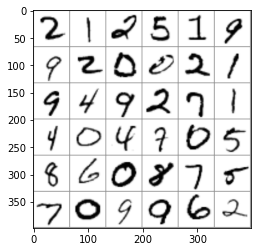

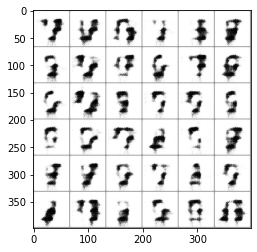

Step 1000: Generator loss: 7.934587708115577, discriminator loss: 5.306602521240711


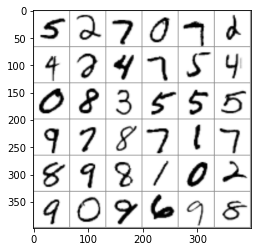

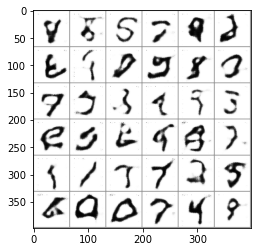

Step 1500: Generator loss: 13.189136546850204, discriminator loss: 3.821165440862533


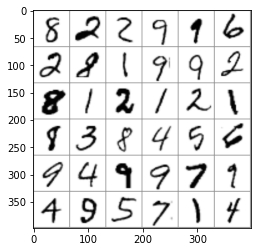

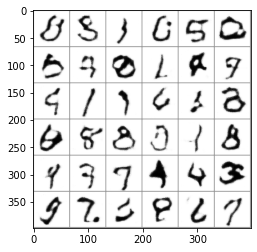

Step 2000: Generator loss: 9.929969298541545, discriminator loss: 4.140366494879126


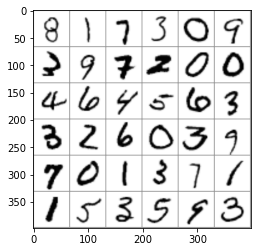

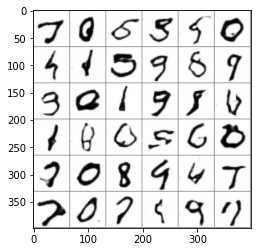

Step 2500: Generator loss: 14.3077166621387, discriminator loss: 3.13563073778525


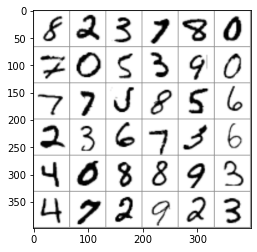

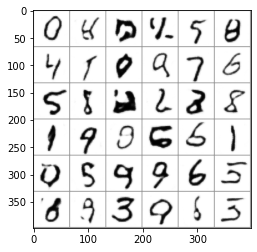

Step 3000: Generator loss: 16.497287212312223, discriminator loss: 2.5564736820012333


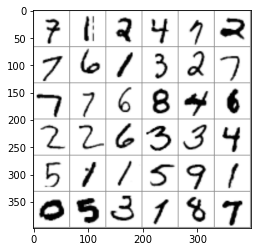

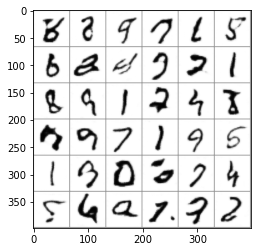

Step 3500: Generator loss: 15.9564108414948, discriminator loss: 2.678521961160004


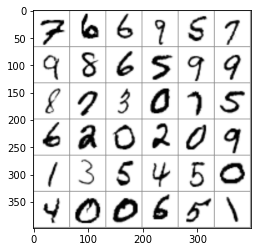

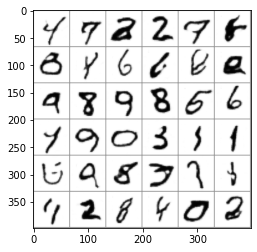

Step 4000: Generator loss: 16.449880292266606, discriminator loss: 2.5297251035133375


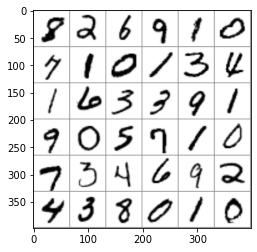

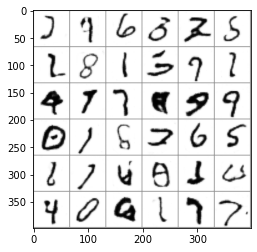

Step 4500: Generator loss: 19.984873641952873, discriminator loss: 1.5245228527486325


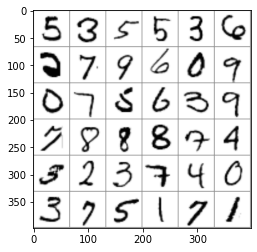

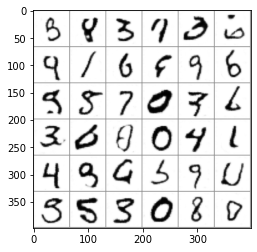

Step 5000: Generator loss: 18.603610210977493, discriminator loss: 2.0911088668182494


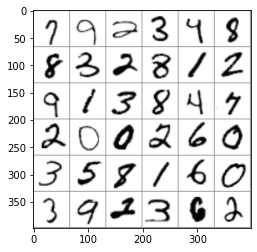

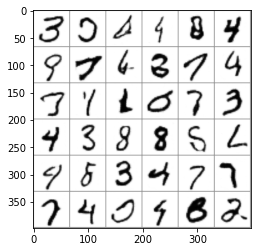

KeyboardInterrupt: 

In [43]:
n_epochs = 25
mean_generator_loss = 0
mean_discriminator_loss = 0
current_step = 0
os.makedirs("DCGAN", exist_ok=True)

for epoch in range(n_epochs):
    for real, _ in(dataloader):
        real = real.to(device)
        
        disc_opt.zero_grad()
        fake_noise = get_noise(len(real), z_dim)
        fake_img = gen(fake_noise)
        disc_preds_fake = disc(fake_img.detach()).reshape(-1)
        disc_fake_loss = criterion(disc_preds_fake, torch.zeros_like(disc_preds_fake))
        disc_fake_loss.backward()
        disc_preds_real = disc(real).reshape(-1)
        disc_real_loss = criterion(disc_preds_real, torch.ones_like(disc_preds_real))
        disc_real_loss.backward()
        disc_loss = disc_fake_loss + disc_real_loss
        
        mean_discriminator_loss += disc_loss.item()  # item() returns the value of tensor as a single python number
        disc_opt.step()
        
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(len(real), z_dim)
        fake_img_2 = gen(fake_noise_2)
        disc_preds_fake2 = disc(fake_img_2).reshape(-1)
        gen_loss = criterion(disc_preds_fake2, torch.ones_like(disc_preds_fake2))
        gen_loss.backward()
        gen_opt.step()
        
        mean_generator_loss += gen_loss.item() 
        
        if current_step % steps == 0 and current_step > 0:
            print(f"Step {current_step}: Generator loss: {mean_generator_loss / 100}, discriminator loss: {mean_discriminator_loss / 100}")
            img_grid_real = torchvision.utils.make_grid(real[:36], nrow = 6)
            img_grid_fake = torchvision.utils.make_grid(fake_img[:36], nrow = 6)
            save_image(fake_img_2.data[:36], "DCGAN/%d.png" % current_step, nrow=6, normalize=True)
            matplotlib_imshow(img_grid_real, one_channel=True)
            matplotlib_imshow(img_grid_fake,  one_channel=True)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        current_step += 1
        